<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0210%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
########################################
# 0. 환경 설정 & 라이브러리 설치
########################################
# Colab에서 Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 import
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)

# TCN
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# 기타
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
라이브러리 임포트 및 한글 폰트 설정 완료!


In [ ]:
def load_data(data_path):
    """
    CSV 파일을 여러 인코딩 방식으로 시도하여 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

# 데이터 로드
DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [ ]:
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균일강수량(mm)','평균풍속(m/s)','평균습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

In [ ]:
# Date 컬럼이 존재한다고 가정
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  평균일강수량(mm)  최다일강수량(mm)  평균풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.0         0.2        1.5   
1  52.897434      2.1        7.8  ...         0.0         0.7        1.3   
2  21.600817      1.3        5.7  ...         0.0         0.7        2.3   
3  18.842018      0.1        6.3  ...         0.3         2.0        1.8   
4  11.594881     -3.6        1.0  ...         0.0        26.0        3.0   

   최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  
0 

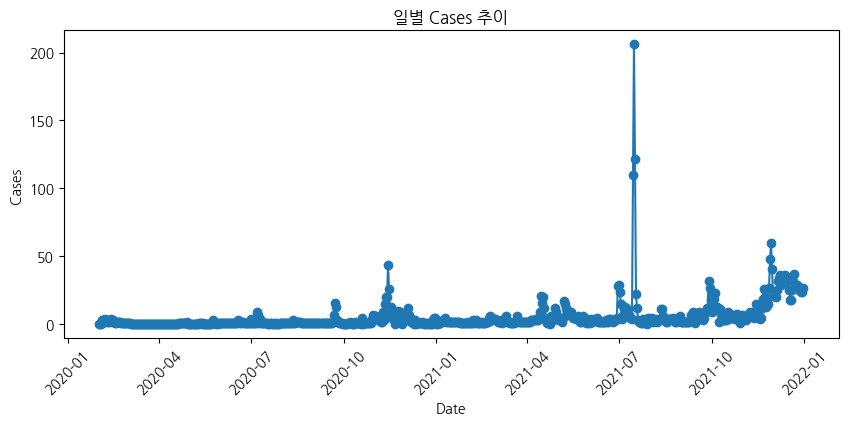

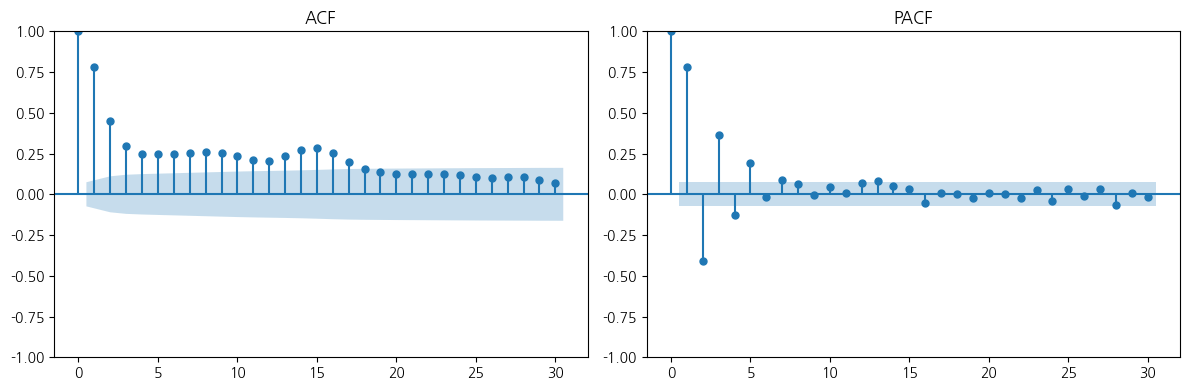

In [ ]:

########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF/PACF 살펴보기
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases'].dropna(), lags=30, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases'].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [ ]:
def create_lag_features(dataframe, col_targets, lags):
    """
    시계열 데이터에 대해 원하는 시차(lags) 만큼의 컬럼 생성.
    예: lags=(1,7,14)이면 col_target_lag1, col_target_lag7, col_target_lag14 추가
    """
    df_ = dataframe.copy()
    for col_target in col_targets:  # Iterate through each column in col_targets
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# 사용 예: feature list
# 기상(가령 O3, PM25 등)이나 교통량(Traffic) 같은 예시 열이 있다고 가정
# 사용자의 실제 상황에 따라 below list 조정하세요


In [ ]:
feature_cols = ['SO2','CO','O3','NO2','평균기온(℃)_lag4', 'PM25_lag9', '평균습도(%rh)_lag4','평균풍속(m/s)_lag10','Traffic',
    'Cases_lag1'
]

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 107), Test=(153, 107)
최종 학습세트 크기: (533, 10) 테스트세트 크기: (153, 10)


In [ ]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

In [ ]:
########################################
# 7. 모델 성능 평가 함수 (MAE, RMSE, MAPE)
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    """
    MAE, RMSE, MAPE 세 가지 지표를 계산하여 dict로 반환
    """
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    # y_true가 0인 케이스 대비를 위해 아주 작은 값 더해주는 것도 방법
    mape_value = mean_absolute_percentage_error(y_true, y_pred)

    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.2f}")
    return {
        'model': model_name,
        'MAE': mae_value,
        'RMSE': rmse_value,
        'MAPE': mape_value
    }

In [ ]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1746.418
Date:                           Mon, 10 Feb 2025   AIC                           3520.836
Time:                                   08:11:35   BIC                           3580.497
Sample:                                        0   HQIC                          3544.200
                                           - 533                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SO2               626.5545   7.81e-06   8.02e+07      0.000     626.554     626.554
CO 

In [ ]:
########################################
# 8-2. LSTM
#  => 시퀀스 형식으로 데이터 변환 필요
########################################
def make_sequence_data(X, y, window=7):
    """
    RNN 계열(LSTM, GRU, CNN-1D 등)을 위해
    window 크기만큼 과거 데이터를 묶어서 (samples, window, features) 형태 반환
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

# 훈련/테스트를 window 시퀀스로 변환
window_size = 7
X_train_seq, y_train_seq = make_sequence_data(X_train_scaled, y_train_scaled, window=window_size)
X_test_seq,  y_test_seq  = make_sequence_data(X_test_scaled, y_test_scaled, window=window_size)

print("LSTM용 시퀀스 데이터 크기:", X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

LSTM용 시퀀스 데이터 크기: (526, 7, 6) (526,) (146, 7, 6) (146,)


In [ ]:
def objective_lstm(trial):
    """
    Optuna를 사용하여 LSTM 모델의 하이퍼파라미터를 조정하는 objective 함수.
    목표: validation loss 최소화
    하이퍼파라미터:
      - lstm_units: LSTM 은닉 유닛 수 (32~256, step=32)
      - dropout_rate: 드롭아웃 비율 (0.1 ~ 0.5, step=0.1)
      - learning_rate: Adam 옵티마이저의 학습률 (1e-4 ~ 1e-2, log scale)
      - batch_size: 배치 사이즈 (16, 32, 64)
    """
    # 하이퍼파라미터 샘플링
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 20  # 튜닝 목적 상 적은 에포크 사용

    # 모델 구성
    model = Sequential()
    model.add(LSTM(lstm_units,
                   activation='tanh',
                   input_shape=(window_size, X_train_seq.shape[2]),
                   return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())

    # EarlyStopping 콜백: validation loss 개선 없으면 중단 (patience=3)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)

    # 모델 학습 (validation_split 사용)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )

    # 가장 낮은 validation loss를 objective 값으로 반환
    val_loss = min(history.history['val_loss'])
    return val_loss

# Optuna 스터디 생성 및 최적화 실행
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective_lstm, n_trials=30)

# 최적의 trial 결과 출력
print("최적의 trial:")
print("Validation Loss:", study.best_trial.value)
print("최적의 하이퍼파라미터:", study.best_trial.params)

[I 2025-02-10 07:31:21,269] A new study created in memory with name: no-name-8c9a997a-be18-49fd-a100-69e548fd2925
<ipython-input-99-820faaa4ddad>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-10 07:31:25,900] Trial 0 finished with value: 103566.453125 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.004377631337977694, 'batch_size': 16}. Best is trial 0 with value: 103566.453125.
[I 2025-02-10 07:31:34,802] Trial 1 finished with value: 159430.0 and parameters: {'lstm_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.004225350551606472, 'batch_size': 64}. Best is trial 0 with value: 103566.453125.
[I 2025-02-10 07:31:42,074] Trial 2 finished with value: 261534.265625 and parameters: {'lstm_units': 160, 'dropout_rate'

최적의 trial:
Validation Loss: 19066.78125
최적의 하이퍼파라미터: {'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.00010299004330084185, 'batch_size': 16}


In [ ]:
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate):
    """
    최적의 하이퍼파라미터를 반영한 간단한 LSTM 모델 구성 예시

    매개변수:
      - input_shape: 입력 데이터의 shape (timesteps, features)
      - lstm_units: LSTM 층의 유닛 수 (예: 64)
      - dropout_rate: Dropout 비율 (예: 0.4)
      - learning_rate: Adam 옵티마이저 학습률 (예: 0.0016895578489875814)
    """
    model_ = Sequential()
    model_.add(LSTM(lstm_units, activation='tanh', input_shape=input_shape, return_sequences=False))
    model_.add(Dropout(dropout_rate))
    model_.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model_.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model_

best_params = study.best_trial.params
# 최적 하이퍼파라미터를 반영하여 모델 생성
lstm_units_best = best_params['lstm_units']
dropout_rate_best = best_params['dropout_rate']
learning_rate_best = best_params['learning_rate']
batch_size_best = best_params['batch_size']
epochs_best = 20

lstm_model = build_lstm_model(
    input_shape=(window_size, X_train_seq.shape[2]),
    lstm_units=lstm_units_best,
    dropout_rate=dropout_rate_best,
    learning_rate=learning_rate_best
)

# 모델 학습
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs_best,
    batch_size=batch_size_best,
    verbose=1
)


Epoch 1/20
27/27 [==============================] - 8s 80ms/step - loss: 4741522.0000 - val_loss: 220371.9375
Epoch 2/20
27/27 [==============================] - 1s 39ms/step - loss: 3812915.0000 - val_loss: 306949.4062
Epoch 3/20
27/27 [==============================] - 1s 26ms/step - loss: 4578218.0000 - val_loss: 104180.0156
Epoch 4/20
27/27 [==============================] - 1s 25ms/step - loss: 3728551.0000 - val_loss: 3404.4370
Epoch 5/20
27/27 [==============================] - 1s 26ms/step - loss: 4096549.7500 - val_loss: 295380.1562
Epoch 6/20
27/27 [==============================] - 1s 25ms/step - loss: 4007717.5000 - val_loss: 85968.5000
Epoch 7/20
27/27 [==============================] - 1s 24ms/step - loss: 3254742.2500 - val_loss: 39710.9141
Epoch 8/20
27/27 [==============================] - 1s 25ms/step - loss: 3524310.7500 - val_loss: 36074.6055
Epoch 9/20
27/27 [==============================] - 1s 24ms/step - loss: 3528928.5000 - val_loss: 115075.4219
Epoch 10/20
27/

In [ ]:
# 예측
lstm_pred_scaled = lstm_model.predict(X_test_seq).flatten()
# 역스케일링
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()

# 테스트셋 실제값(역스케일링)
y_test_seq_inversed = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

lstm_result = evaluate_performance(y_test_seq_inversed, lstm_pred, model_name="LSTM")

5/5 [==============================] - 1s 9ms/step
[LSTM] MAE=10.930, RMSE=15.976, MAPE=0.70%


In [ ]:
def objective_gru(trial):
    """
    Optuna를 사용하여 GRU 모델의 하이퍼파라미터를 조정하는 objective 함수.
    목표: validation loss 최소화

    하이퍼파라미터:
      - gru_units: GRU 은닉 유닛 수 (32~256, step=32)
      - dropout_rate: 드롭아웃 비율 (0.1 ~ 0.5, step=0.1)
      - learning_rate: Adam 옵티마이저의 학습률 (1e-4 ~ 1e-2, log scale)
      - batch_size: 배치 사이즈 (16, 32, 64)
    """
    # 하이퍼파라미터 샘플링
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 20  # 튜닝 목적 상 적은 에포크 사용

    # 모델 구성: GRU 레이어 사용
    model = Sequential()
    model.add(GRU(gru_units,
                  activation='tanh',
                  input_shape=(window_size, X_train_seq.shape[2]),
                  return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())

    # EarlyStopping 콜백: validation loss 개선 없으면 중단 (patience=3)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)

    # 모델 학습 (validation_split 사용)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )

    # 가장 낮은 validation loss를 objective 값으로 반환
    val_loss = min(history.history['val_loss'])
    return val_loss

# GRU 모델에 대해 Optuna 스터디 생성 및 최적화 실행
import optuna
study_gru = optuna.create_study(direction='minimize')
study_gru.optimize(objective_gru, n_trials=30)

# 최적의 trial 결과 출력
print("최적의 GRU trial:")
print("Validation Loss:", study_gru.best_trial.value)
print("최적의 하이퍼파라미터:", study_gru.best_trial.params)


# 최적의 GRU trial:
# Validation Loss: 0.014153774827718735
# 최적의 하이퍼파라미터: {'gru_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00026388338318862067, 'batch_size': 64}

[I 2025-02-10 07:39:12,632] A new study created in memory with name: no-name-85febb66-f74d-4bc4-8a97-dd88b3959844
<ipython-input-102-a172da32b08c>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-10 07:39:22,519] Trial 0 finished with value: 229942.03125 and parameters: {'gru_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.005688825348614405, 'batch_size': 16}. Best is trial 0 with value: 229942.03125.
[I 2025-02-10 07:39:28,986] Trial 1 finished with value: 66381.546875 and parameters: {'gru_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00568975923093802, 'batch_size': 32}. Best is trial 1 with value: 66381.546875.
[I 2025-02-10 07:39:42,155] Trial 2 finished with value: 42926.2265625 and parameters: {'gru_units': 224, 'dropout_rate':

최적의 GRU trial:
Validation Loss: 20523.4765625
최적의 하이퍼파라미터: {'gru_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0005356597665008875, 'batch_size': 16}


In [ ]:
########################################
# 8-3. GRU
########################################
def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate):
    """
    최적 하이퍼파라미터를 반영한 간단한 GRU 모델 구성 예시

    매개변수:
      - input_shape: 입력 데이터의 shape (timesteps, features)
      - gru_units: GRU 층의 유닛 수 (예: 192)
      - dropout_rate: Dropout 비율 (예: 0.5)
      - learning_rate: Adam 옵티마이저 학습률 (예: 0.00026388338318862067)
    """
    model_ = Sequential()
    model_.add(GRU(gru_units, activation='tanh', input_shape=input_shape, return_sequences=False))
    model_.add(Dropout(dropout_rate))
    model_.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model_.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model_

In [ ]:
# 최적의 GRU trial:
# Validation Loss: 0.014153774827718735
# 최적의 하이퍼파라미터: {'gru_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00026388338318862067, 'batch_size': 64}

In [ ]:
# 최적 하이퍼파라미터 값 적용
gru_units_best = 256
dropout_rate_best = 0.4
learning_rate_best = 0.0005356597665008875
batch_size_best = 16
epochs_best = 20

# GRU 모델 생성 (최적 하이퍼파라미터 반영)
gru_model = build_gru_model(
    input_shape=(window_size, X_train_seq.shape[2]),
    gru_units=gru_units_best,
    dropout_rate=dropout_rate_best,
    learning_rate=learning_rate_best
)

# GRU 모델 학습
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs_best,
    batch_size=batch_size_best,
    verbose=1
)

# 예측 및 역스케일링
gru_pred_scaled = gru_model.predict(X_test_seq).flatten()
gru_pred = scaler_y.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()

# 평가 함수로 성능 지표 계산 (MAE, RMSE, MAPE)
gru_result = evaluate_performance(y_test_seq_inversed, gru_pred, model_name="GRU")

Epoch 1/20
27/27 [==============================] - 6s 81ms/step - loss: 8355372.0000 - val_loss: 836277.3125
Epoch 2/20
27/27 [==============================] - 1s 44ms/step - loss: 10994838.0000 - val_loss: 370588.0000
Epoch 3/20
27/27 [==============================] - 1s 52ms/step - loss: 7161678.0000 - val_loss: 1160412.8750
Epoch 4/20
27/27 [==============================] - 1s 45ms/step - loss: 7093936.0000 - val_loss: 136309.3594
Epoch 5/20
27/27 [==============================] - 1s 49ms/step - loss: 7921099.0000 - val_loss: 316976.4375
Epoch 6/20
27/27 [==============================] - 1s 45ms/step - loss: 10305876.0000 - val_loss: 354004.2500
Epoch 7/20
27/27 [==============================] - 1s 39ms/step - loss: 6681127.0000 - val_loss: 781828.0625
Epoch 8/20
27/27 [==============================] - 1s 24ms/step - loss: 6237846.5000 - val_loss: 178214.0000
Epoch 9/20
27/27 [==============================] - 1s 24ms/step - loss: 5084729.5000 - val_loss: 439780.1250
Epoch 1

In [ ]:
########################################
# 8-4. CNN (1D Convolution)
########################################
def build_cnn_model(input_shape, conv_filters=32, kernel_size=3, dropout_rate=0.2):
    """
    1D CNN 모델 예시
    Conv1D -> MaxPooling1D -> Flatten -> Dense(1)
    """
    model_ = Sequential()
    model_.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, padding='causal',
                      activation='relu', input_shape=input_shape))
    model_.add(MaxPooling1D(pool_size=2))
    model_.add(Dropout(dropout_rate))
    model_.add(Flatten())
    model_.add(Dense(1))
    model_.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model_

In [ ]:

cnn_model = build_cnn_model(input_shape=(window_size, X_train_seq.shape[2]),
                            conv_filters=32, kernel_size=3, dropout_rate=0.2)
history_cnn = cnn_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=1
)

cnn_pred_scaled = cnn_model.predict(X_test_seq).flatten()
cnn_pred = scaler_y.inverse_transform(cnn_pred_scaled.reshape(-1,1)).flatten()
cnn_result = evaluate_performance(y_test_seq_inversed, cnn_pred, model_name="CNN")

Epoch 1/20
27/27 [==============================] - 1s 9ms/step - loss: 28650570.0000 - val_loss: 6086717.0000
Epoch 2/20
27/27 [==============================] - 0s 5ms/step - loss: 20558860.0000 - val_loss: 2926153.0000
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 18834100.0000 - val_loss: 1841511.8750
Epoch 4/20
27/27 [==============================] - 0s 5ms/step - loss: 13205961.0000 - val_loss: 1330632.5000
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 11224018.0000 - val_loss: 1522361.6250
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 9894117.0000 - val_loss: 616310.4375
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 7869912.0000 - val_loss: 653972.8125
Epoch 8/20
27/27 [==============================] - 0s 4ms/step - loss: 6332684.0000 - val_loss: 135313.0938
Epoch 9/20
27/27 [==============================] - 0s 4ms/step - loss: 7653337.5000 - val_loss: 383210.4375
Epoch 10/

In [ ]:
########################################
# 9. XGBoost (일반 회귀, 시퀀스 변환 없이 직접 예측)
########################################
#  => X_train_scaled, y_train_scaled 사용
#     (window 기반 안 쓰고, 단일 행 -> 예측)
########################################
xgb_model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)

# 예측
xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1,1)).flatten()
xgb_result = evaluate_performance(y_test, xgb_pred, model_name="XGBoost")

[XGBoost] MAE=4.113, RMSE=6.640, MAPE=0.57%


In [ ]:

########################################
# 10. SVM (SVR)
########################################
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)

svr_pred_scaled = svr_model.predict(X_test_scaled)
svr_pred = scaler_y.inverse_transform(svr_pred_scaled.reshape(-1,1)).flatten()
svr_result = evaluate_performance(y_test, svr_pred, model_name="SVM(SVR)")

[SVM(SVR)] MAE=10.398, RMSE=11.990, MAPE=2.29%


In [ ]:
########################################
# 11. Prophet (Meta의 시계열)
#     -> 'ds', 'y' 필수 컬럼
#     -> 외생변수(regressor) 이용 가능
########################################
def train_prophet(train_df_, test_df_, extra_regressors):
    """
    Prophet 모델을 학습한 뒤, test 기간 예측값을 반환
    train_df_ / test_df_는 다음 형식 컬럼 필요: 'ds'(날짜), 'y'(목표변수) + extra_regressors
    """
    # 모델 선언
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,  # 일 데이터 기준이면 True
        seasonality_mode='additive',
        changepoint_prior_scale=0.1
    )
    # 외생변수 추가
    for col in extra_regressors:
        prophet_model.add_regressor(col)

    # 학습
    prophet_model.fit(train_df_)

    # 예측
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values

    forecast = prophet_model.predict(future)
    return prophet_model, forecast

In [ ]:
# Prophet용 데이터 준비
# Prophet은 ds, y 컬럼 필요
prophet_train = pd.DataFrame({
    'ds': train_df['Date'],
    'y': train_df['Cases']
})
prophet_test = pd.DataFrame({
    'ds': test_df['Date'],
    'y': test_df['Cases']
})

In [ ]:
# 동일한 외생변수 컬럼 prophet_train / prophet_test에 추가
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col] = test_df[col].values

prophet_model, prophet_forecast = train_prophet(
    prophet_train, prophet_test,
    extra_regressors=feature_cols
)

prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxc30j76r/b40zf95e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxc30j76r/ec771ogb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41896', 'data', 'file=/tmp/tmpxc30j76r/b40zf95e.json', 'init=/tmp/tmpxc30j76r/ec771ogb.json', 'output', 'file=/tmp/tmpxc30j76r/prophet_model_k9_vuia/prophet_model-20250210074454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.475, RMSE=6.032, MAPE=0.78%



=== 모델별 성능 지표 비교 ===


,model,MAE,RMSE,MAPE(%)
0,SARIMAX,3.883009,5.882402,0.488399
1,LSTM,10.929631,15.975966,0.699825
2,GRU,7.458545,11.472467,0.672798
3,CNN,12.603897,18.667102,1.049008
4,XGBoost,4.113435,6.639507,0.565078
5,SVM(SVR),10.398399,11.990279,2.288754
6,Prophet,4.474859,6.031662,0.778073


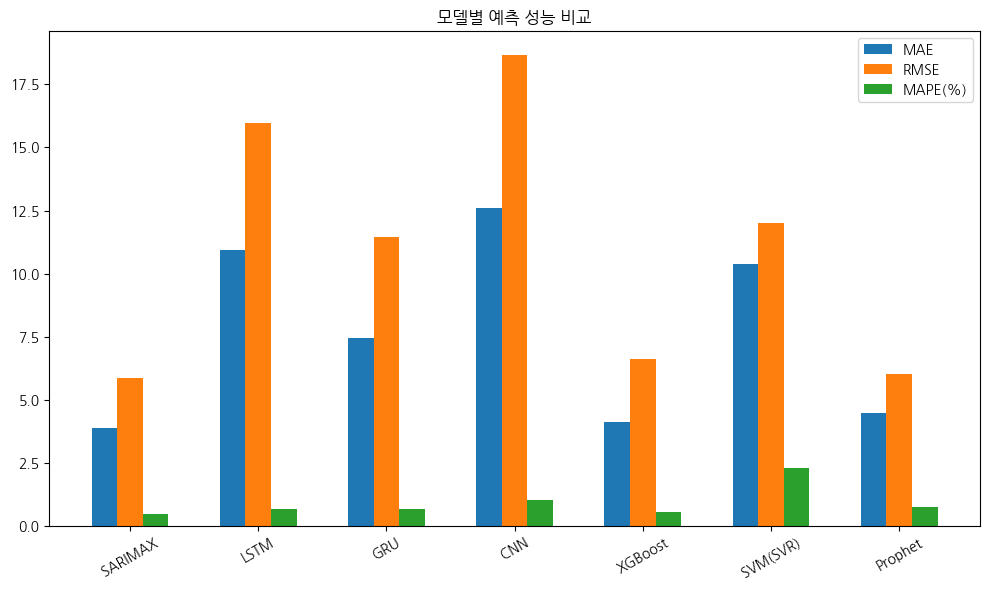


작업 완료! 각 모델의 성능 지표가 results_df에 정리되었습니다.


106939

In [ ]:
########################################
# 12. 결과 비교 (MAE, RMSE, MAPE)
########################################
results_df = pd.DataFrame([
    sarimax_result, lstm_result, gru_result, cnn_result,
    xgb_result, svr_result, prophet_result
])
print("\n=== 모델별 성능 지표 비교 ===")
display(results_df)

# 시각화
plt.figure(figsize=(10,6))
bar_x = np.arange(len(results_df))
plt.bar(bar_x - 0.2, results_df['MAE'], 0.2, label='MAE')
plt.bar(bar_x,         results_df['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.2,   results_df['MAPE(%)'], 0.2, label='MAPE')
plt.xticks(bar_x, results_df['model'], rotation=30)
plt.title("모델별 예측 성능 비교")
plt.legend()
plt.tight_layout()
plt.show()


########################################
# 13. 마무리
########################################
print("\n작업 완료! 각 모델의 성능 지표가 results_df에 정리되었습니다.")
gc.collect()